Installs

In [ ]:
!pip install -U ray==2.38.0  # <- Important version!
!pip install -U gymnasium
!pip install -U mujoco

!apt-get install -y \
   libgl1-mesa-dev \
   libgl1-mesa-glx \
   libglew-dev \
   libosmesa6-dev \
   software-properties-common

!apt-get install -y patchelf

!pip install free-mujoco-py
!pip install -U moderngl
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1  # for rendering OpenGL

from __future__ import annotations

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
import gymnasium as gym

!pip install gputil
!pip install lz4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 17.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
The following additional packages will be installed:
  libegl-dev libgl-dev libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev
  libglvnd-dev libglx-dev libopengl-dev libosmesa6
The following NEW packages will be installed:
  libegl-dev libgl-dev libgl1-mesa-dev libgl1-mesa-glx libgles-dev libgles1 libglew-dev
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libopengl-dev libosmesa6
  libos

Load XML

In [ ]:
from google.colab import drive
import os
import shutil

# Mount the drive
mount_path = '/content/drive'
drive.mount(mount_path, force_remount=True)

# Path to the directory for models and XML file
models_path = '/content/drive/MyDrive/checkpoints/models/'

# Ensure the directory exists
os.makedirs(models_path, exist_ok=True)

# Upload the hockey.xml file if not already uploaded
uploaded_xml_file = os.path.join(models_path, 'hockey.xml')
if not os.path.exists(uploaded_xml_file):
    from google.colab import files
    print("Please upload the 'hockey.xml' file.")
    uploaded = files.upload()
    for filename in uploaded.keys():
        shutil.move(filename, uploaded_xml_file)
    print(f"'{uploaded_xml_file}' uploaded successfully.")
else:
    print(f"'{uploaded_xml_file}' already exists.")

# Validate the hockey.xml file
if not os.path.exists(uploaded_xml_file):
    raise FileNotFoundError(f"'{uploaded_xml_file}' was not found.")
else:
    print(f"'{uploaded_xml_file}' is ready for use.")


Mounted at /content/drive
'/content/drive/MyDrive/checkpoints/models/hockey.xml' already exists.
The required file '/content/drive/MyDrive/checkpoints/models/hockey.xml' is ready for use.


In [ ]:
plt.rcParams["figure.figsize"] = (10, 5)

Environment

In [ ]:
import numpy as np
from gymnasium.spaces import Discrete
from gymnasium import utils
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium.spaces import Box
import os

drive.mount('/content/drive')

# Modified using https://github.com/denisgriaznov/CustomMuJoCoEnviromentForRL as a template
class HockeyEnv(MujocoEnv, utils.EzPickle):
    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "depth_array",
        ],
        "render_fps": 50,
    }

    def __init__(self, episode_len=100, **kwargs):
        utils.EzPickle.__init__(self, **kwargs)
        observation_space = Box(low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32)
        MujocoEnv.__init__(
            self,
            os.path.abspath(models_path + "hockey.xml"),
            10,
            observation_space=observation_space,
            **kwargs
        )
        self.step_number = 0.0
        self.episode_len = episode_len
        self.goal_made = False
        self.action_space = Discrete(4)

    def step(self, a):
        reward = -0.1  # Encourage movement

        if a == 0:  # up
            force = [0, 1]
        elif a == 1:  # down
            force = [0, -1]
        elif a == 2:  # left
            force = [-1, 0]
        elif a == 3:  # right
            force = [1, 0]

        scaled_force = np.array(force) * 10
        self.do_simulation(scaled_force, self.frame_skip)
        self.step_number += 1.0
        goal_touched = False

        for i in range(self.data.ncon):
            contact = self.data.contact[i]
            geom1 = contact.geom1
            geom2 = contact.geom2
            gid = self.data.geom("goalgeom").id
            pid = self.data.geom("puckgeom").id

            if (geom1 == gid and geom2 == pid) or (geom1 == pid and geom2 == gid):
                new_rgba = [0.0, 1.0, 0.0, 0.9]  # Goal turns green
                self.model.geom_rgba[gid] = new_rgba
                goal_touched = True

        obs = self._get_obs()
        done = False

        # Calculate distances
        puck_joint_id = self.model.joint("puck_joint").qposadr
        puck_position = [
            self.data.qpos[puck_joint_id],  # x
            self.data.qpos[puck_joint_id + 1],  # y
        ]
        player_x_index = self.model.joint("player_x").qposadr
        player_y_index = self.model.joint("player_y").qposadr
        player_position = [
            self.data.qpos[player_x_index],
            self.data.qpos[player_y_index] - 0.5,
        ]

        distance_to_puck = np.linalg.norm(np.array(player_position) - np.array(puck_position))
        distance_to_goal = np.linalg.norm(np.array(puck_position) - [self.random_goal_x, 0.925])

        # Reward logic
        reward -= distance_to_puck  # Penalize being far from the puck
        reward -= distance_to_goal * 0.5  # Encourage moving the puck

        if goal_touched:
            done = True
            if not self.goal_made:
                reward += 1000  # Large reward = scoring
                self.goal_made = True

        truncated = self.step_number >= float(self.episode_len)
        return obs, reward, done, truncated, {}

    def reset_model(self):
        self.step_number = 0.0
        self.goal_made = False
        gid = self.data.geom("goalgeom").id
        new_rgba = [0.0, 1.0, 0.0, 0.2]
        self.model.geom_rgba[gid] = new_rgba

        self.random_goal_x = np.random.uniform(-0.5, 0.5)
        qpos = self.init_qpos + self.np_random.uniform(size=self.model.nq, low=-0.01, high=0.01)
        qvel = self.init_qvel + self.np_random.uniform(size=self.model.nv, low=-0.01, high=0.01)
        self.set_state(qpos, qvel)
        return self._get_obs()

    def _get_obs(self):
        obs = np.concatenate(
            (
                np.array(self.data.joint("puck_joint").qpos[:3]),
                np.array(self.data.joint("player_x").qpos[:3]),
                np.array(self.data.joint("player_y").qpos[:3]),
            ),
            axis=0,
        )
        return obs


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


PPO

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Image, display
import imageio
import numpy as np
from ray.rllib.algorithms.ppo import PPOConfig
from ray import tune

tune.register_env("my_env", lambda config: HockeyEnv())

# PPO
config = (
    PPOConfig()
    .environment(env="my_env")
    .env_runners(num_env_runners=0)
    .training(train_batch_size=1024, lambda_=0.95, num_epochs=10)
)
algo = config.build()

# Train
num_iterations = 10
for i in range(num_iterations):
    result = algo.train()
    print(f"Iteration {i + 1}: Mean Reward: {result.get('episode_reward_mean', 'N/A')}")

# Helper function
def add_text_to_frame(frame, text, x, y):
    """
    Adds text overlay to a rendered frame.

    Args:
        frame (np.array): The original frame (RGB array).
        text (str): The text to overlay.
        x (int): X-coordinate for the text.
        y (int): Y-coordinate for the text.

    Returns:
        np.array: The frame with text overlay.
    """
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.imshow(frame)
    ax.axis("off")
    ax.text(
        x,
        y,
        text,
        color="yellow",
        fontsize=14,
        fontweight="bold",
        backgroundcolor="black",
    )
    fig.canvas.draw()
    frame_with_text = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame_with_text = frame_with_text.reshape(
        fig.canvas.get_width_height()[::-1] + (3,)
    )
    plt.close(fig)
    return frame_with_text

# Function to render a policy episode
def render_policy_episode(env, algo, extra_frames=10):
    """
    Renders a policy episode with the trained agent.

    Args:
        env (HockeyEnv): The environment to render.
        algo: The trained RLlib algorithm.
        extra_frames (int): Extra frames to append for smoother GIF ending.

    Returns:
        list: A list of frames (np.array) for the GIF.
    """
    obs, info = env.reset()
    frames = []
    total_reward = 0
    terminated, truncated = False, False

    while not (terminated or truncated):
        # Compute action using the trained policy
        action = algo.compute_single_action(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

        # Render the frame and overlay the reward text
        frame = env.render()
        if frame is not None:
            frame_with_text = add_text_to_frame(
                frame, f"Total Reward: {total_reward:.2f}", 10, 25
            )
            frames.append(frame_with_text)

    for _ in range(extra_frames):
        frames.append(frame_with_text)

    env.close()
    return frames

# GIF
try:
    # Initialize the Hockey environment for rendering
    env = HockeyEnv(render_mode="rgb_array", camera_name="topdown")

    frames = render_policy_episode(env, algo)
    gif_filename = "trained_policy.gif"
    imageio.mimsave(gif_filename, frames, fps=20)
    display(Image(filename=gif_filename))  # Display GIF
except Exception as e:
    print(f"An error occurred during rendering: {e}")


In [ ]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray import tune
import os
import matplotlib.pyplot as plt
from google.colab import drive

# Define constants
num_iterations = 1000  # Change for training
batch_size = 1024
lambda_ = 0.95

tune.register_env("my_env", lambda config: HockeyEnv())

config = (
    PPOConfig()
    .environment(env="my_env")
    .rollouts(batch_mode="truncate_episodes")
    .training(
        train_batch_size=batch_size,
        lambda_=lambda_,
        num_sgd_iter=30,
        clip_param=0.2,
    )
    .resources(num_gpus=0)
    .framework("torch")
)

if 'algo' in globals():
    algo.stop()
    del algo

# Build algorithm
algo = config.build()

# Mount Google Drive for saving checkpoints
drive.mount('/content/drive')
checkpoint_path = '/content/drive/MyDrive/checkpoints/models/current'
os.makedirs(checkpoint_path, exist_ok=True)

# Track the best model and training progress
best_mean_reward = float('-inf')
best_checkpoint_dir = '/content/drive/MyDrive/checkpoints/models/best'
os.makedirs(best_checkpoint_dir, exist_ok=True)

# Store history for plotting
reward_mean_history = []
reward_min_history = []
reward_max_history = []

# Training loop
for i in range(num_iterations):
    result = algo.train()
    reward_mean = result.get("episode_reward_mean", None)
    reward_min = result.get("episode_reward_min", None)
    reward_max = result.get("episode_reward_max", None)

    # Best model
    if reward_mean is not None and reward_mean > best_mean_reward:
        best_mean_reward = reward_mean
        best_checkpoint_path = algo.save(best_checkpoint_dir)
        print(f"New best model saved with mean reward: {best_mean_reward:.2f}")

    # Save rewards
    if reward_mean is not None:
        reward_mean_history.append(reward_mean)
    if reward_min is not None:
        reward_min_history.append(reward_min)
    if reward_max is not None:
        reward_max_history.append(reward_max)

    # Save checkpoints periodically
    if i % 10 == 0:
        checkpoint_dir = algo.save(checkpoint_path)
        print(f"Checkpoint saved at iteration {i} in directory {checkpoint_dir}")

        # Plot reward history
        plt.figure(figsize=(10, 6))
        plt.plot(reward_mean_history, label="Mean Reward")
        plt.plot(reward_min_history, label="Min Reward", linestyle='--')
        plt.plot(reward_max_history, label="Max Reward", linestyle='--')
        plt.xlabel("Iterations")
        plt.ylabel("Reward")
        plt.title("Reward Progress Over Iterations")
        plt.legend()
        plt.show()

# Save final checkpoint
final_checkpoint_path = algo.save(checkpoint_path)
print(f"Final checkpoint saved at {final_checkpoint_path}")


In [ ]:
#SKIP THIS CELL to just use the last iteration of algo from above
### To restore the checkpointed training

from ray import tune
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import Image, display
import imageio
import time


tune.register_env("my_env", lambda config: HockeyEnv())

# Clean up any previous algorithm instance
if 'algo' in globals():
    algo.stop()
    del algo

checkpoint_path = '/content/drive/MyDrive/checkpoints/models/checklambda.08'
restore_me = checkpoint_path# '/content/drive/MyDrive/checkpoints/models/check3'
from ray.rllib.algorithms.ppo import PPOConfig
config = PPOConfig().environment(env="my_env").training(train_batch_size=512)
# config.resources(num_gpus=.05)
# Build.
algo = config.build()
algo.restore(restore_me)

Tests

Exception ignored in: <function GLContext.__del__ at 0x7fee2b66f910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/mujoco/glfw/__init__.py", line 41, in __del__
    self.free()
  File "/usr/local/lib/python3.10/dist-packages/mujoco/glfw/__init__.py", line 34, in free
    if self._context:
AttributeError: 'GLContext' object has no attribute '_context'


Saved trial-0.gif


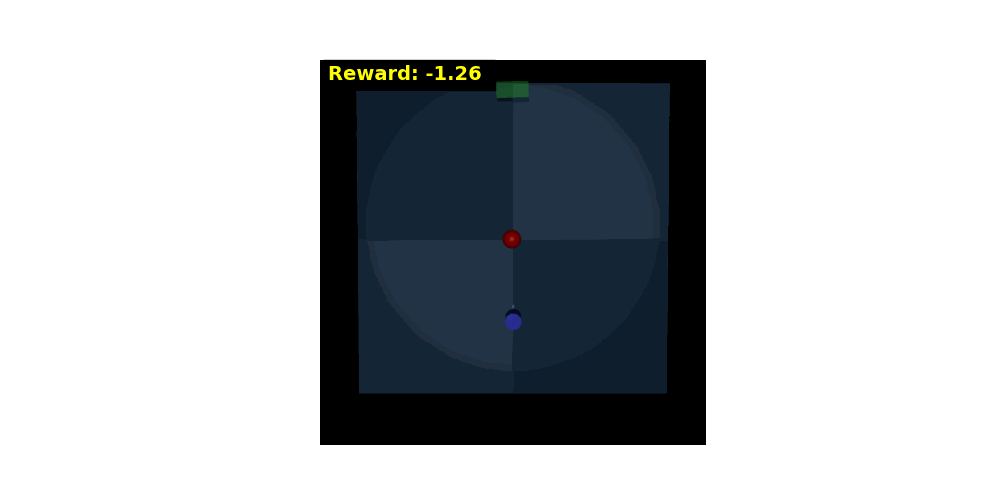

Saved trial-1.gif


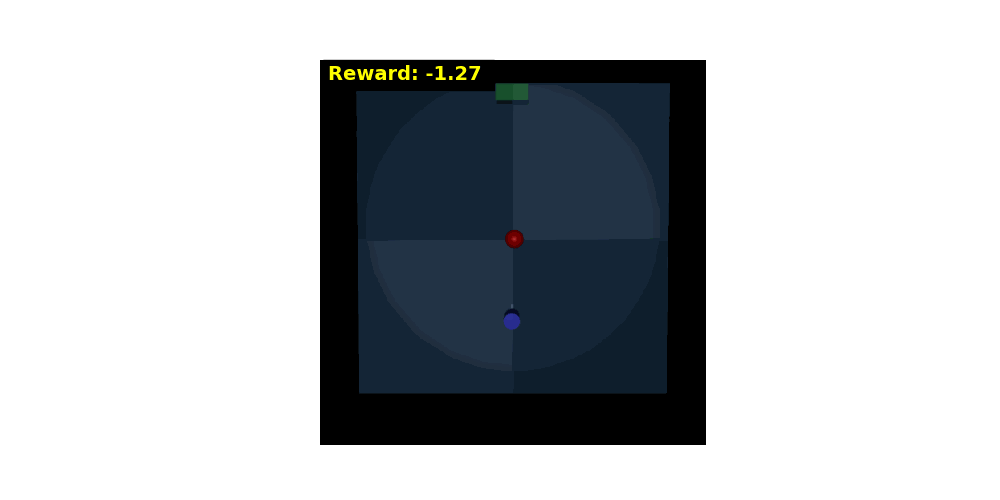

Saved trial-2.gif


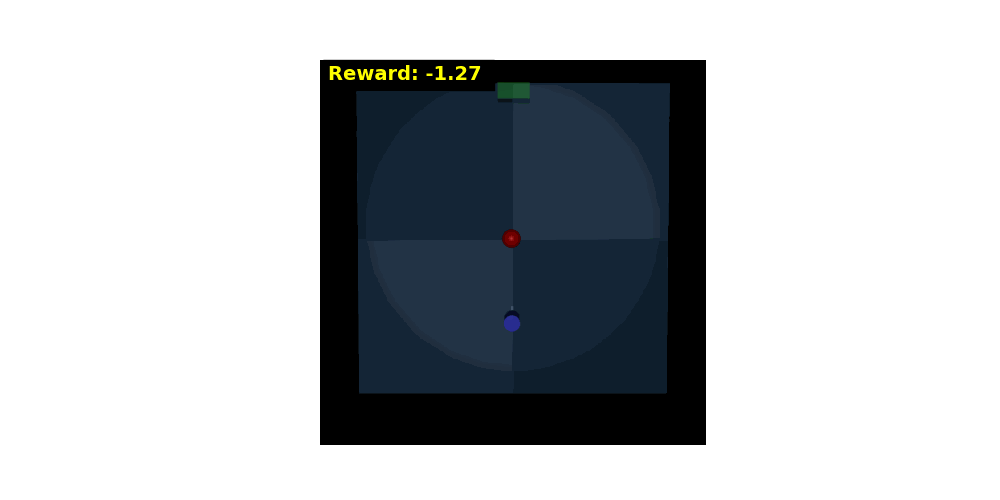

Saved trial-3.gif


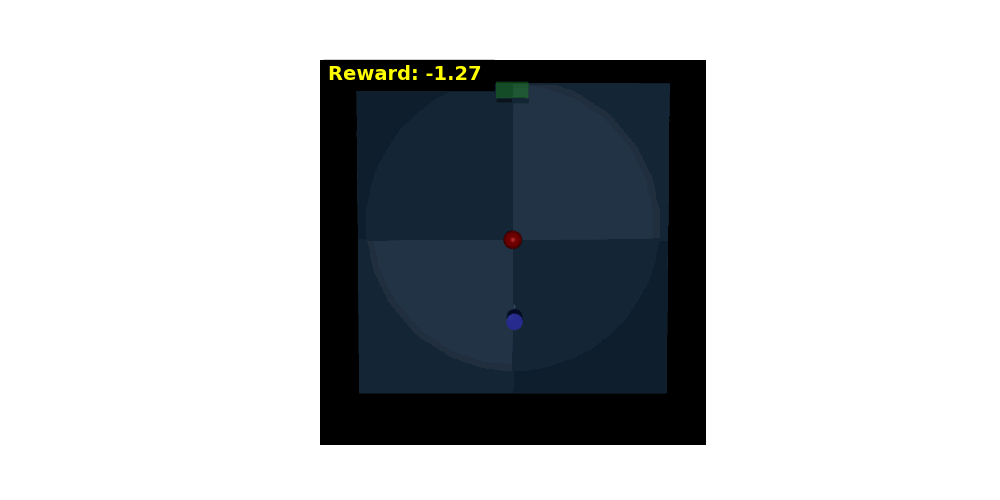

Saved trial-4.gif


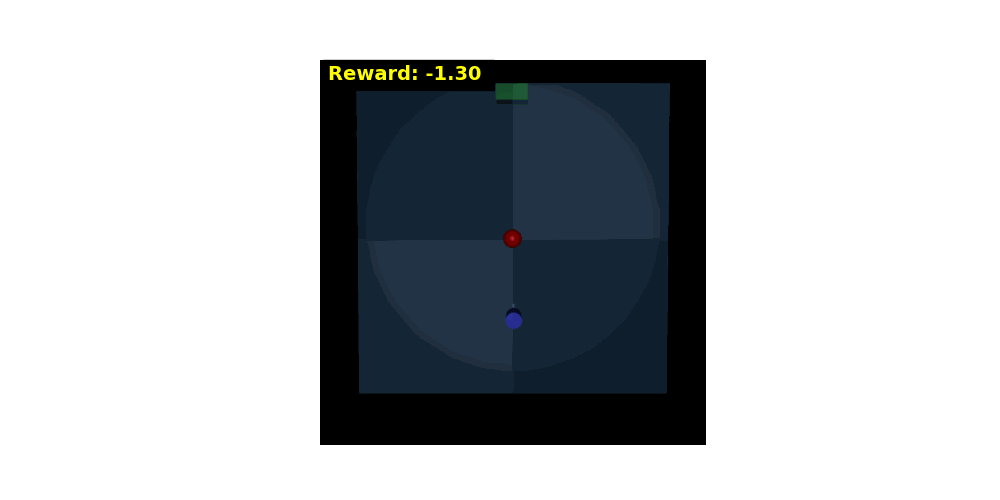

Saved trial-5.gif


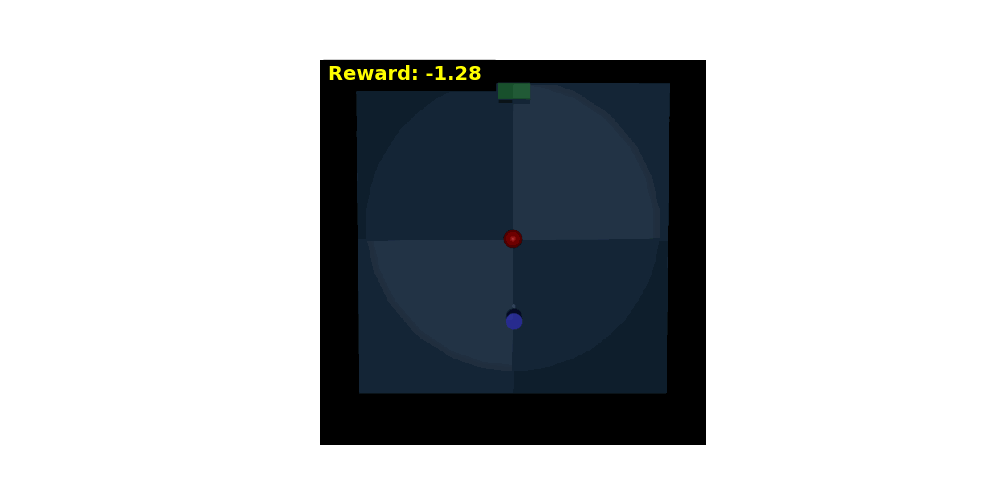

Saved trial-6.gif


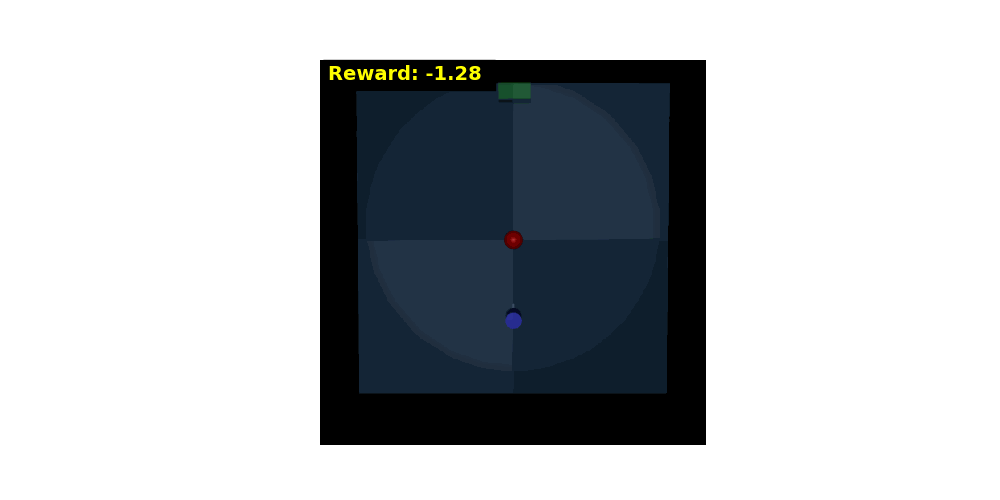

Saved trial-7.gif


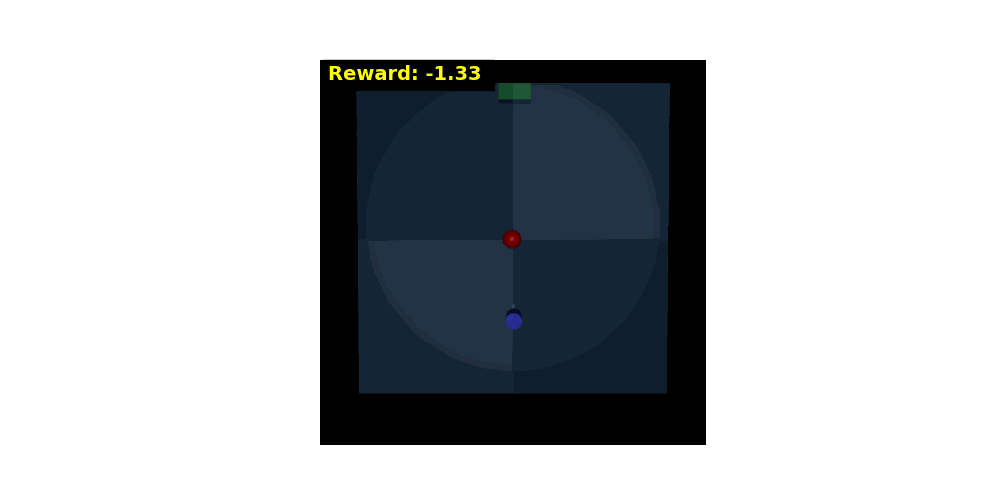

Saved trial-8.gif


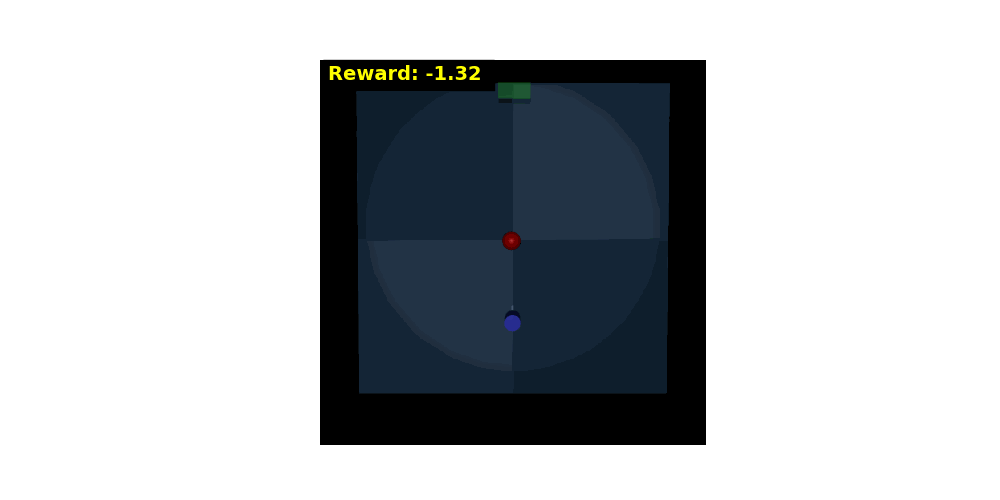

Saved trial-9.gif


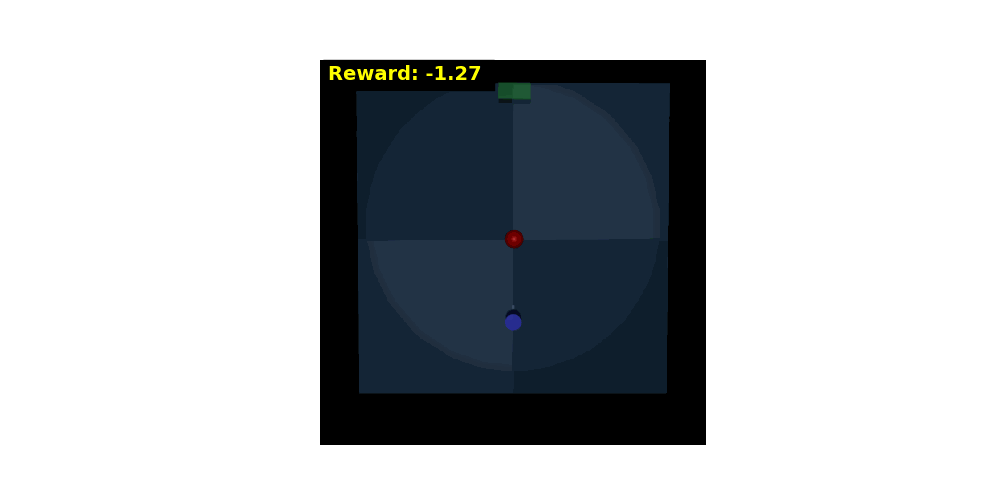

In [ ]:
 ## Tests the policy in algo

example_runs = 10
prepend_to_gif_file = "trial-"


#Testing "algo" and demonstrating its use with GIFs
policy = algo.get_policy()

import matplotlib.pyplot as plt
from IPython.display import Image, display
import imageio

env = HockeyEnv(render_mode="rgb_array",camera_name="topdown")


def add_text_to_frame(frame, text, x, y):
    # Convert the frame to a Matplotlib figure with the text overlay
    fig, ax = plt.subplots()
    ax.imshow(frame)
    ax.axis('off')  # Hide axes
    ax.text(x, y, text, color="yellow", fontsize=14, fontweight='bold', backgroundcolor='black')
    fig.canvas.draw()
    # Convert the Matplotlib figure back to an image array
    frame_with_text = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    frame_with_text = frame_with_text.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # RGBA channels
    plt.close(fig)  # Close the figure to save memory
    return frame_with_text

def render_policy_episode(env, extra_frames=10):
    env.reset()
    step_counter = 0
    keep_rendering = True
    obs, info = env.reset()
    frames = []
    total_reward = 0
    while keep_rendering:
        action = policy.compute_single_action(obs)[0]
        obs, reward, terminated, truncated, ddd = env.step(action)
        total_reward += reward
        frame = env.render()  # Assuming "rgb_array" mode
        frame_with_text = add_text_to_frame(frame, f"Reward: {total_reward:.2f} ", 10, 25)
        frames.append(frame_with_text)
        # Check for done or truncated flags and start counting extra frames
        if terminated or truncated:
            step_counter += 1
            if step_counter >= extra_frames:
                keep_rendering = False
                break
        else:
            step_counter = 0  # Reset the counter if not done/truncated
    return frames

for i in range(example_runs):
    frames = render_policy_episode(env,3)
    savefilename = prepend_to_gif_file+str(i)+'.gif'
    imageio.mimsave(savefilename, frames, fps=20, loop=0)#0 goes forever
    print("Saved "+savefilename)
    display(Image(filename=savefilename))

# Summary of RL Training Tasks:

## The Initial Bad Hockey Player:
- The agent was set up using a PPO configuration. It began performing random actions, doing poorly, but this helped to lay the template for further changes and visualization.  
- The focus was on letting the agent explore and become familiar with basic movement and action feedback.  

**SEE:** SLIDE 3 in “G3 - GIFS - Project 2”

---

## Fixed Goal:
- The agent was trained with a fixed starting position and a consistent goal location.  
- The training taught the agent to move the puck toward the goal efficiently, optimizing rewards for reaching the target.  
- After more training, the agent started improving and began scoring more consistently.  

**SEE:** SLIDES 3-6 & 8 in “G3 - GIFS - Project 2”

---

## Random Start Goal:
- Random starting positions for both the puck and the agent were implemented for the agent to learn to adapt to varied goal position scenarios.  
- The training process focused on handling different setups while still scoring on the goal.  
- The agent developed more flexible strategies and could perform reliably under varying conditions.  

---

# Reflection on Failures:

### 1) Agent Ignoring the Puck:
- At first, the agent completely ignored the puck and just wandered around. The reward function didn’t push the agent to actually engage with the puck.  
- Fixed it by adding rewards for getting closer to the puck.  

**SEE:** SLIDE 7, gif 1 in “G3 - GIFS - Project 2”

---

### 2) Agent Getting Close to the Puck and Backing Away:
- Sometimes the agent would get close to the puck but then back away or just circle around it, due to the reward function not penalizing wasted movement.  
- By tweaking the rewards and refining the action mapping, the agent sticks with the puck and moves toward the goal more effectively.  

**SEE:** SLIDE 8, gif 2 in “G3 - GIFS - Project 2”

---

### 3) Agent Getting Close to Scoring (Fine-Tuning):
- As the agent got better, it started getting the puck near the goal but didn’t quite score or hit the goal-post.  
- Added extra rewards for reducing the puck’s distance to the goal and fine-tuned the training with more exploration.  

**SEE:** SLIDE 8, gif 3 in “G3 - GIFS - Project 2”

---

# Reflection on Key Changes:
- One of the biggest breakthroughs came from improving the reward function and refining the observation space.  
- By rewarding the agent for moving closer to the puck and the goal, there was a noticeable improvement in its behavior.  
- Updating the observation space to include details like puck velocity helped the agent make better decisions in the environment.  
- If we could do it differently, we’d prioritize creating a stronger reward system and focus on optimizing hyperparameters earlier in the testing process.  
- Exploring more advanced techniques for exploration and training stability might have also saved time and avoided some of the struggles we faced throughout.  

**SEE:** SLIDE 9, in “G3 - GIFS - Project 2”
